<a href="https://colab.research.google.com/github/BongoniDevendarGoud/IMBD-MOVIE-EDA/blob/main/IMBD_MOVIE_SUCCESS_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [ ]:
basics = pd.read_csv("/content/title.basics.tsv", sep='\t')
ratings = pd.read_csv("/content/title.ratings.tsv", sep='\t')
crew = pd.read_csv("/content/title.crew.tsv", sep='\t')
episode = pd.read_csv("/content/title.episode.tsv", sep='\t')
names = pd.read_csv("/content/name.basics.tsv", sep='\t')


In [ ]:
basics.head()
basics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12230885 entries, 0 to 12230884
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         int64 
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: int64(1), object(8)
memory usage: 839.8+ MB


In [ ]:
ratings.head()
ratings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1627362 entries, 0 to 1627361
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1627362 non-null  object 
 1   averageRating  1627362 non-null  float64
 2   numVotes       1627362 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 37.2+ MB


In [ ]:
movies = basics[basics['titleType'] == 'movie'].copy()


In [ ]:
movies['startYear'] = pd.to_numeric(movies['startYear'], errors='coerce')
movies['runtimeMinutes'] = pd.to_numeric(movies['runtimeMinutes'], errors='coerce')


In [ ]:
movies = movies.merge(ratings, on='tconst', how='left')
movies = movies.dropna(subset=['averageRating', 'numVotes'])
movies = movies[movies['numVotes'] >= 1000]


In [ ]:
movies = movies.merge(
    crew[['tconst', 'directors', 'writers']],
    on='tconst',
    how='left'
)


In [ ]:
movies.describe()


,isAdult,startYear,runtimeMinutes,averageRating,numVotes
count,40385.000000,40385.000000,40385.000000,40385.000000,4.038500e+04
mean,0.000371,2008.719277,106.502043,6.159802,2.811678e+04
std,0.019269,12.698995,22.629467,1.197166,1.034461e+05
min,0.000000,1975.000000,43.000000,1.000000,1.000000e+03
25%,0.000000,2002.000000,92.000000,5.500000,1.707000e+03
50%,0.000000,2012.000000,101.000000,6.300000,3.509000e+03
75%,0.000000,2019.000000,116.000000,7.000000,1.190200e+04
max,1.000000,2026.000000,746.000000,10.000000,3.146989e+06


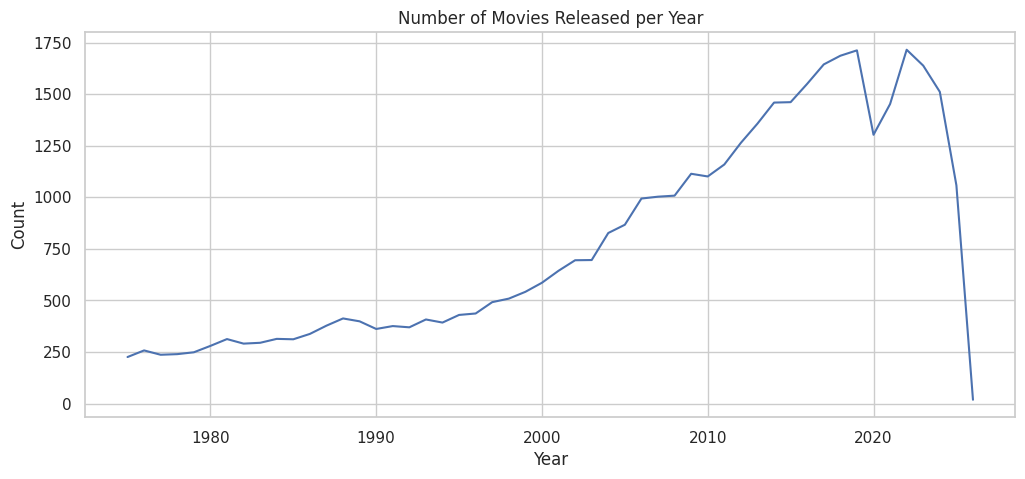

In [ ]:
movies_per_year = movies.groupby('startYear').size()

plt.figure(figsize=(12,5))
movies_per_year.plot()
plt.title("Number of Movies Released per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()


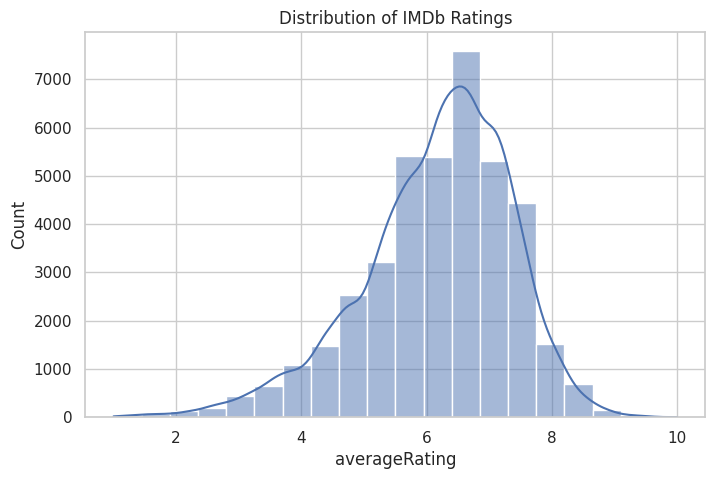

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(movies['averageRating'], bins=20, kde=True)
plt.title("Distribution of IMDb Ratings")
plt.show()


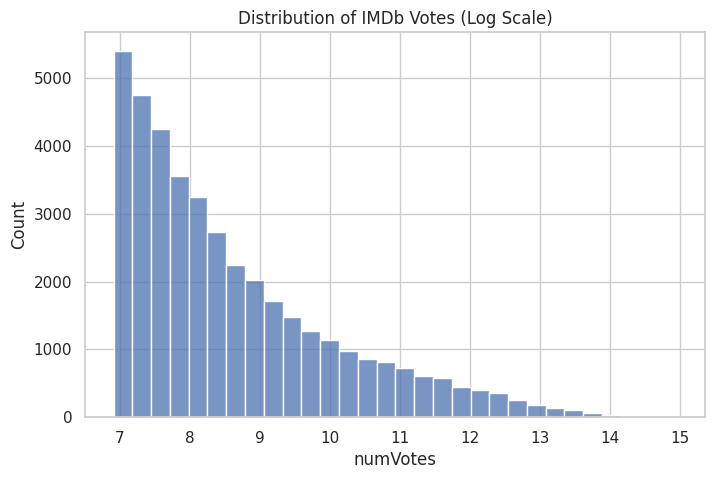

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(movies['numVotes']), bins=30)
plt.title("Distribution of IMDb Votes (Log Scale)")
plt.show()


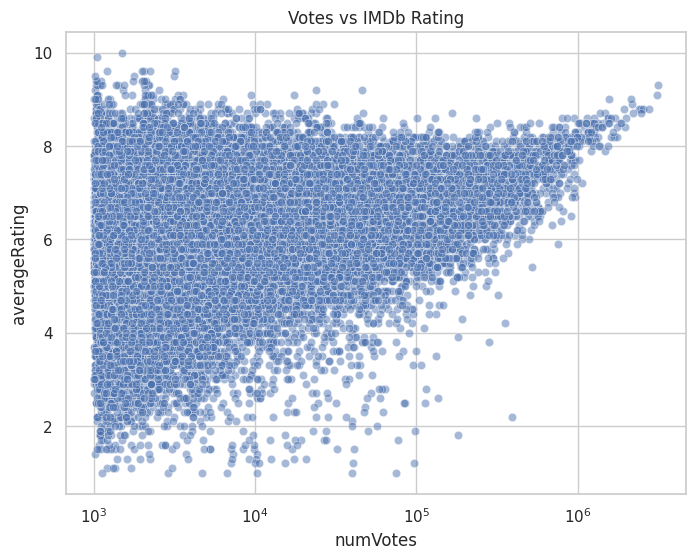

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=movies,
    x='numVotes',
    y='averageRating',
    alpha=0.5
)
plt.xscale('log')
plt.title("Votes vs IMDb Rating")
plt.show()


In [ ]:
movies[['numVotes', 'averageRating']].corr()


,numVotes,averageRating
numVotes,1.000000,0.192337
averageRating,0.192337,1.000000


In [ ]:
movies['genres'] = movies['genres'].str.split(',')
movies_genres = movies.explode('genres')


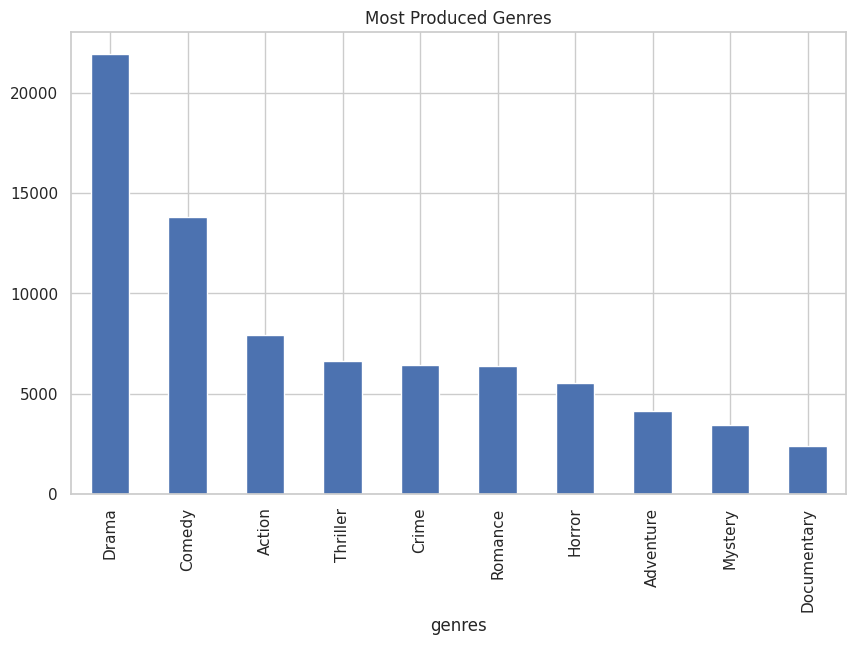

In [ ]:
genre_count = movies_genres['genres'].value_counts()

plt.figure(figsize=(10,6))
genre_count.head(10).plot(kind='bar')
plt.title("Most Produced Genres")
plt.show()


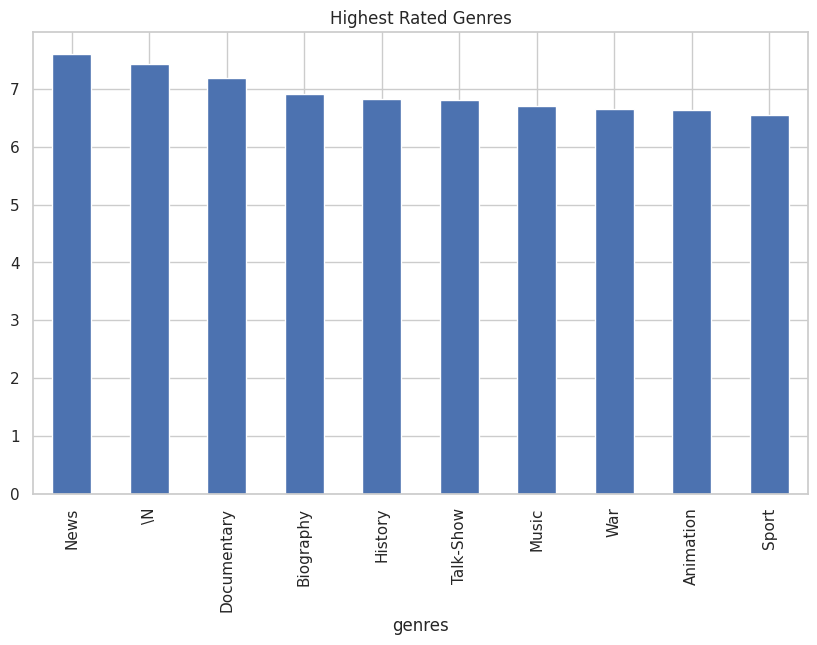

In [ ]:
genre_rating = (
    movies_genres
    .groupby('genres')['averageRating']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,6))
genre_rating.head(10).plot(kind='bar')
plt.title("Highest Rated Genres")
plt.show()


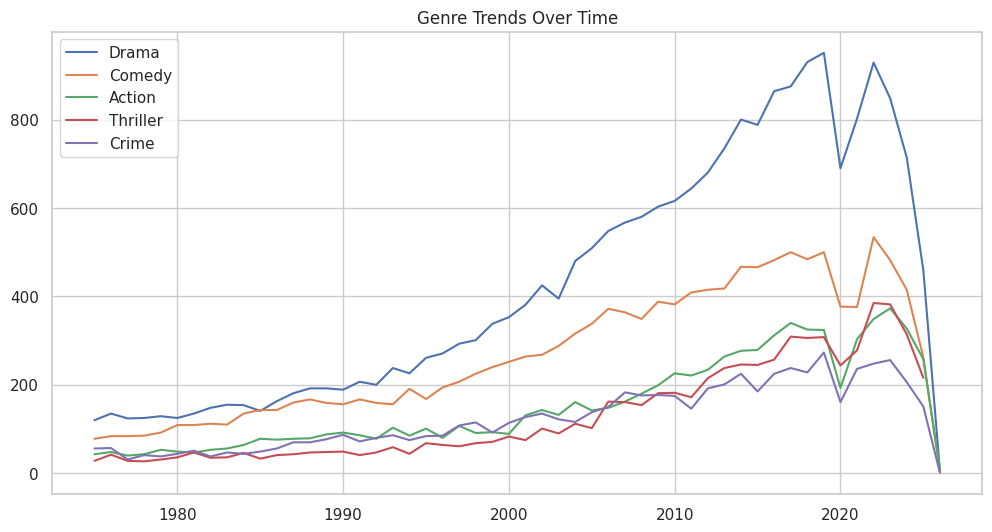

In [ ]:
genre_year = (
    movies_genres
    .groupby(['startYear','genres'])
    .size()
    .reset_index(name='count')
)

top_genres = genre_count.head(5).index

plt.figure(figsize=(12,6))
for g in top_genres:
    data = genre_year[genre_year['genres'] == g]
    plt.plot(data['startYear'], data['count'], label=g)

plt.legend()
plt.title("Genre Trends Over Time")
plt.show()


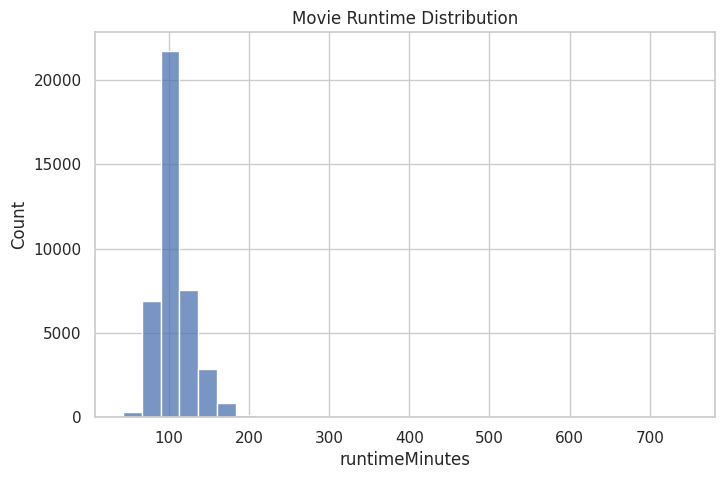

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(movies['runtimeMinutes'], bins=30)
plt.title("Movie Runtime Distribution")
plt.show()


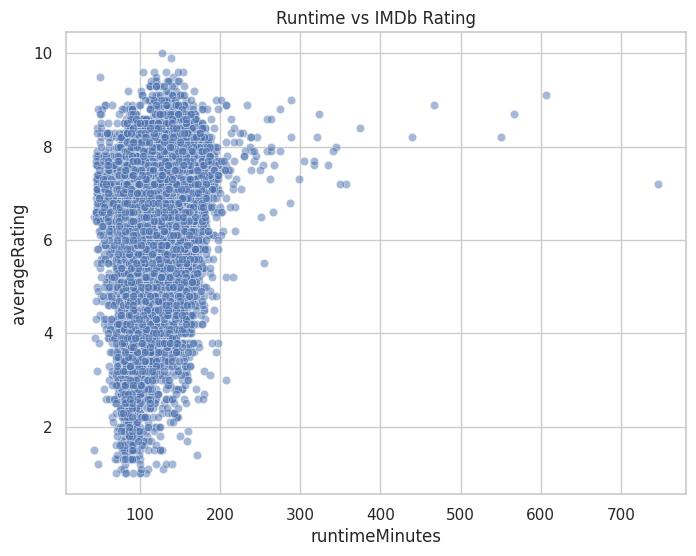

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=movies,
    x='runtimeMinutes',
    y='averageRating',
    alpha=0.5
)
plt.title("Runtime vs IMDb Rating")
plt.show()


In [ ]:
movies[['runtimeMinutes','averageRating']].corr()


,runtimeMinutes,averageRating
runtimeMinutes,1.000000,0.290525
averageRating,0.290525,1.000000


In [ ]:
movies['directors'] = movies['directors'].str.split(',')
movies_directors = movies.explode('directors')


In [ ]:
movies_directors = movies_directors.merge(
    names[['nconst','primaryName']],
    left_on='directors',
    right_on='nconst',
    how='left'
)


In [ ]:
director_rating = (
    movies_directors
    .groupby('primaryName')
    .agg(
        avg_rating=('averageRating','mean'),
        movie_count=('tconst','count')
    )
    .query("movie_count >= 5")
    .sort_values(by='avg_rating', ascending=False)
)

director_rating.head(10)


,avg_rating,movie_count
primaryName,,
Park Jun-soo,8.387500,8
Humayun Ahmed,8.320000,5
Haruo Sotozaki,8.200000,8
Upendra,8.200000,7
Digpal Lanjekar,8.200000,5
Lee Unkrich,8.180000,5
Christopher Nolan,8.166667,12
K. Balachander,8.120000,5
Vetrimaaran,8.114286,7


In [ ]:
director_consistency = (
    movies_directors
    .groupby('primaryName')
    .agg(
        avg_rating=('averageRating','mean'),
        std_rating=('averageRating','std'),
        movie_count=('tconst','count')
    )
    .query("movie_count >= 5")
    .sort_values(by='std_rating')
)

director_consistency.head(10)


,avg_rating,std_rating,movie_count
primaryName,,,
Richard Gray,5.416667,0.098319,6
Jan Svankmajer,7.266667,0.103280,6
Park Jun-soo,8.387500,0.112599,8
Eytan Fox,7.140000,0.114018,5
Sydney Sibilia,6.940000,0.134164,5
Adolfo Aristarain,7.620000,0.148324,5
Tim Mielants,6.640000,0.151658,5
Brett Haley,6.650000,0.151658,6
Eric Darnell,6.700000,0.158114,5


In [ ]:
movies['writers'] = movies['writers'].str.split(',')
movies_writers = movies.explode('writers')


In [ ]:
movies_writers = movies_writers.merge(
    names[['nconst','primaryName']],
    left_on='writers',
    right_on='nconst',
    how='left'
)


In [ ]:
writer_rating = (
    movies_writers
    .groupby('primaryName')
    .agg(
        avg_rating=('averageRating','mean'),
        movie_count=('tconst','count')
    )
    .query("movie_count >= 5")
    .sort_values(by='avg_rating', ascending=False)
)

writer_rating.head(10)


,avg_rating,movie_count
primaryName,,
Jonathan Nolan,8.620000,5
Jandhyala,8.580000,5
Upendra,8.200000,7
Digpal Lanjekar,8.200000,5
Koyoharu Gotouge,8.200000,8
Dusan Kovacevic,8.171429,7
Humayun Ahmed,8.171429,7
Rajasri,8.160000,5
Christopher Nolan,8.158333,12


In [ ]:
tv_titles = episode['parentTconst'].unique()
movies['is_tv_related'] = movies['tconst'].isin(tv_titles)

movies.groupby('is_tv_related')['averageRating'].mean()


,averageRating
is_tv_related,
False,6.159802


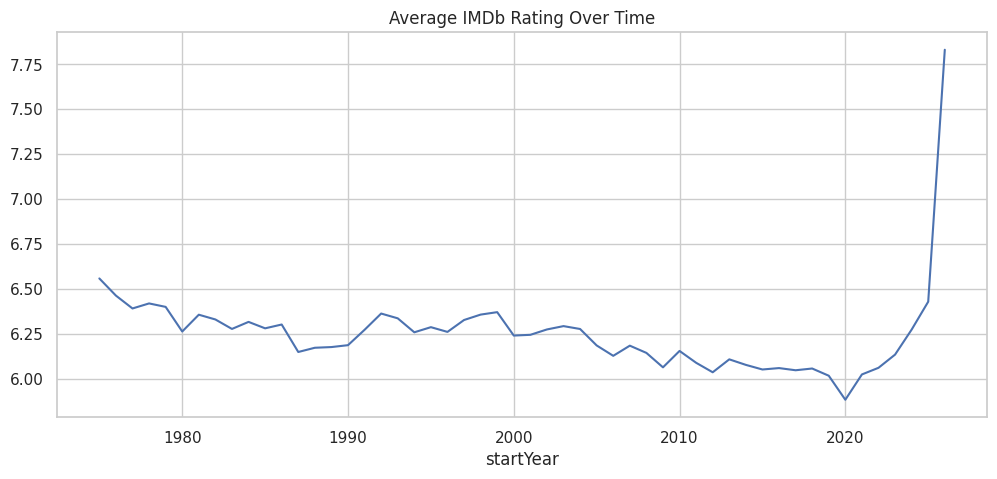

In [ ]:
yearly_rating = movies.groupby('startYear')['averageRating'].mean()

plt.figure(figsize=(12,5))
yearly_rating.plot()
plt.title("Average IMDb Rating Over Time")
plt.show()


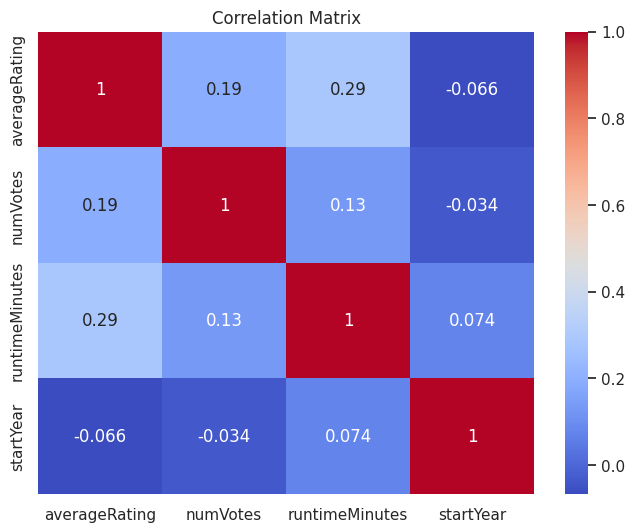

In [ ]:
corr = movies[['averageRating','numVotes','runtimeMinutes','startYear']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [ ]:
movies['rating_bucket'] = pd.cut(
    movies['averageRating'],
    bins=[0,6,7,8,10],
    labels=['Low','Average','Good','Excellent']
)

movies['rating_bucket'].value_counts()


,count
rating_bucket,
Low,16336
Average,14506
Good,8354
Excellent,1189


In [ ]:
movies = basics[basics['titleType'] == 'movie'].copy()
movies['startYear'] = pd.to_numeric(movies['startYear'], errors='coerce')
movies['runtimeMinutes'] = pd.to_numeric(movies['runtimeMinutes'], errors='coerce')

In [ ]:
movies = movies.dropna(subset=['startYear', 'runtimeMinutes', 'genres'])
movies = movies[movies['runtimeMinutes'] > 0]


In [ ]:
movies = movies[movies['startYear'] >= 1975]


In [ ]:
movies = movies.merge(ratings, on='tconst', how='left')


In [ ]:
movies = movies.dropna(subset=['averageRating', 'numVotes'])
movies = movies[movies['numVotes'] >= 1000]


In [ ]:
movies = movies.merge(crew[['tconst', 'directors']], on='tconst', how='left')


In [ ]:
movies['genres'] = movies['genres'].str.split(',')
movies_genres = movies.explode('genres')


In [ ]:
genre_rating = (
    movies_genres
    .groupby('genres')
    .averageRating
    .mean()
    .sort_values(ascending=False)
)

genre_rating.head(10)


,averageRating
genres,
News,7.592857
\N,7.432222
Documentary,7.186043
Biography,6.904517
History,6.813485
Talk-Show,6.800000
Music,6.700784
War,6.643890
Animation,6.625520


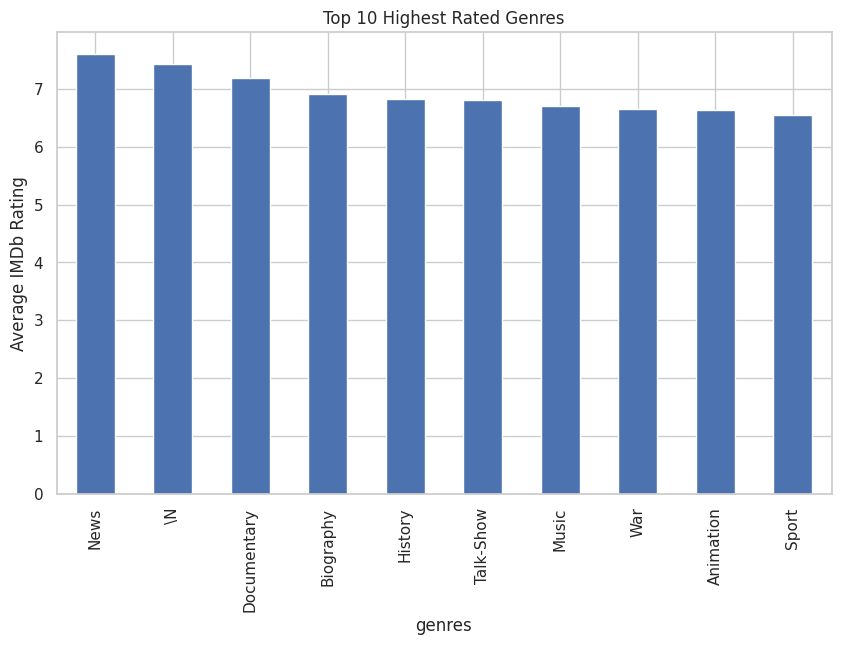

In [ ]:
plt.figure(figsize=(10,6))
genre_rating.head(10).plot(kind='bar')
plt.title("Top 10 Highest Rated Genres")
plt.ylabel("Average IMDb Rating")
plt.show()


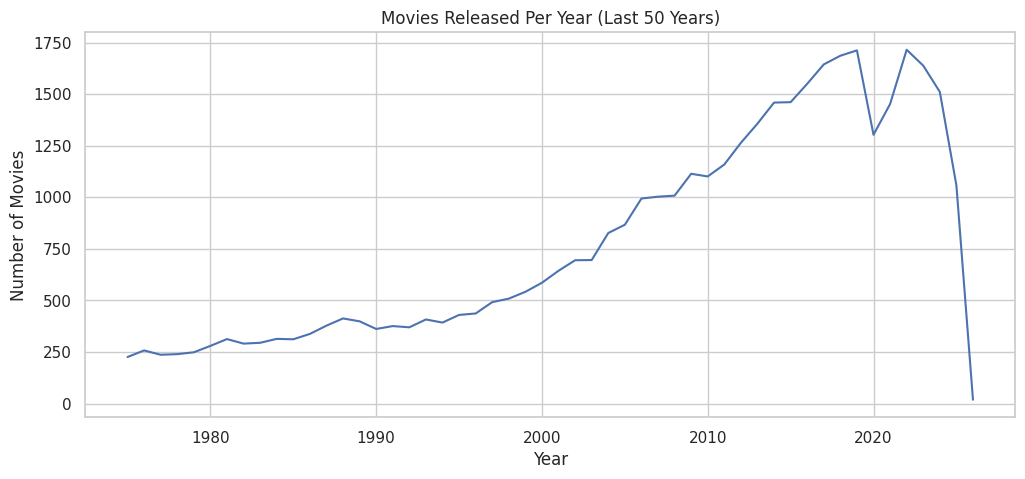

In [ ]:
movies_per_year = movies.groupby('startYear').size()

plt.figure(figsize=(12,5))
movies_per_year.plot()
plt.title("Movies Released Per Year (Last 50 Years)")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.show()


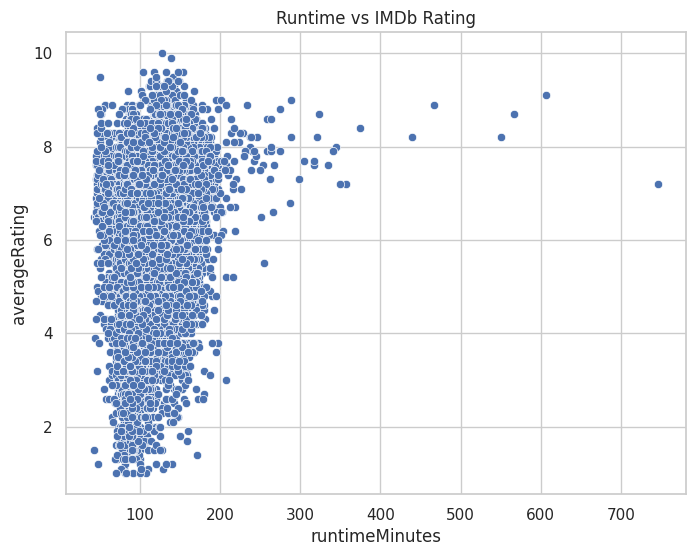

,runtimeMinutes,averageRating
runtimeMinutes,1.000000,0.290525
averageRating,0.290525,1.000000


In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=movies, x='runtimeMinutes', y='averageRating')
plt.title("Runtime vs IMDb Rating")
plt.show()

movies[['runtimeMinutes', 'averageRating']].corr()


In [ ]:
movies['directors'] = movies['directors'].str.split(',')
movies_directors = movies.explode('directors')


In [ ]:
movies_directors = movies_directors.merge(
    names[['nconst', 'primaryName']],
    left_on='directors',
    right_on='nconst',
    how='left'
)


In [ ]:
director_rating = (
    movies_directors
    .groupby('primaryName')
    .agg(
        avg_rating=('averageRating','mean'),
        movie_count=('tconst','count')
    )
    .query("movie_count >= 5")
    .sort_values(by='avg_rating', ascending=False)
)

director_rating.head(10)


,avg_rating,movie_count
primaryName,,
Park Jun-soo,8.387500,8
Humayun Ahmed,8.320000,5
Haruo Sotozaki,8.200000,8
Upendra,8.200000,7
Digpal Lanjekar,8.200000,5
Lee Unkrich,8.180000,5
Christopher Nolan,8.166667,12
K. Balachander,8.120000,5
Vetrimaaran,8.114286,7


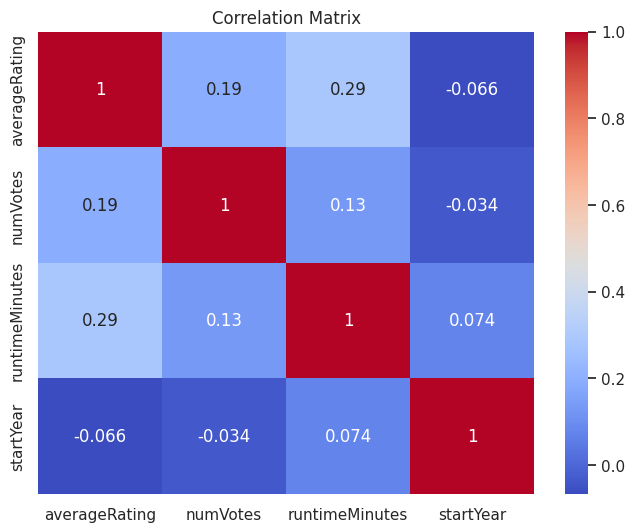

In [ ]:
corr = movies[['averageRating', 'numVotes', 'runtimeMinutes', 'startYear']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()
